In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

sns.set()

random_state = 123_456
np.random.seed(random_state)

In [2]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

### Using non_categorical_features

In [3]:
non_categorical_features = ['price','tapis_oil_price_t_minus_10','wholesale_price_t_minus_4']
# non_categorical_features = ['price','wholesale_price_t_minus_4','tapis_oil_price_t_minus_10',
#                             'sgd_exchange_rate_t_minus_6']

In [4]:
tscv = TimeSeriesSplit(n_splits=8, max_train_size=100)
tscv

TimeSeriesSplit(max_train_size=100, n_splits=8)

In [5]:
list_train_test = list()

for train, test in tscv.split(df):
#     print("%s %s" % (train, test))
#     print("%s" % (test))
    df_train = df.iloc[train]
    df_test = df.iloc[test][:len(train)]
    list_train_test.append(dict(train=df_train, test=df_test))
#     print(df_train.shape)
#     print(df_test.shape)
#     break
# list_train_test

In [6]:
# df_train[-3:]

In [7]:
# df_test[:3]

In [8]:
best = None
max_r2 = None

for train_test in list_train_test:
    X_train = train_test['train'][non_categorical_features].copy()
    y_train = train_test['train'][['price_t_plus_1']].copy()
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    results = model.fit()
#     X_test = train_test['test'][['price']].copy()
#     y_test = train_test['test'][['price_t_plus_1']].copy()
    X_test = df[non_categorical_features].copy()
    y_test = df[['price_t_plus_1']].copy()
    X_test = sm.add_constant(X_test)
    y_hat = np.rint(results.predict(X_test))
#     y_hat += 30
    this_r2 = r2_score(y_test, y_hat)
    
    if not max_r2 or this_r2 > max_r2:
        max_r2 = this_r2
        best = y_hat
        
    print(round(results.rsquared_adj,3), this_r2)
#     print(round(results.rsquared_adj,3), results.params.const, results.params.price, r2_score(y_test, y_hat))
#     print(results.summary())
#     break

0.78 0.9194439631050609
0.9 0.9175790578771518
0.735 0.9401236618909052
0.86 0.9227709410370533
0.818 0.9392619275612633
0.97 0.9496716830761516
0.923 0.9440629500719268
0.876 0.9365341449604099


/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwar

In [9]:
max_r2

0.9496716830761516

In [10]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

In [11]:
error_tolerance_percentage = 2.5
get_relative_accuracy(y_test.values, best, error_tolerance_percentage)

0.8922374429223744

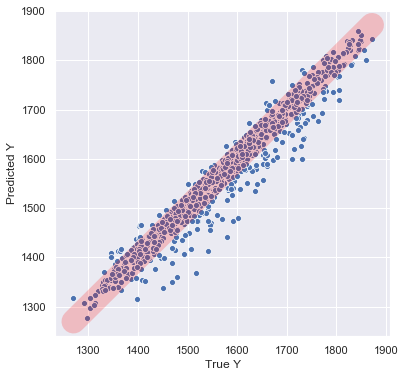

In [12]:
line_x_y = [math.floor(min(y_test.values.min(),best.min())), math.ceil(max(y_test.values.max(),best.max()))]
_ = plt.figure(figsize = (6, 6))
_ = plt.plot(line_x_y, line_x_y, linewidth=24, alpha=0.2, color='red')
_ = sns.scatterplot(y_test.values.reshape(1,-1)[0], best.values)
_ = plt.ylabel('Predicted Y')
_ = plt.xlabel('True Y')
plt.show()